In [86]:
import numpy as np
import matplotlib.pyplot as plt

In [95]:
# Parameters for simulation
np.random.seed(42)
num_users = 100  # Reduce size for faster gradient-based implementation
num_content = 100
time_steps = 10
learning_rate = 0.001  # Learning rate for gradient descent
max_iterations = 5000  # Maximum iterations for convergence
epsilon = 1e-5  # Convergence threshold

In [96]:
# User and content distributions (random for simplicity)
user_distribution = [np.random.dirichlet(np.ones(num_users)) for _ in range(time_steps)]
content_distribution = [np.random.dirichlet(np.ones(num_content)) for _ in range(time_steps)]

In [97]:
# Engagement function (randomized for simulation)
engagement = [np.random.rand(num_users, num_content) for _ in range(time_steps)]
# Polarization scores for content (randomized)
polarization = [np.random.rand(num_content) for _ in range(time_steps)]

In [98]:
# Constraints
engagement_min = [50 for _ in range(time_steps)]  # Minimum engagement threshold
polarization_max = [0.1 for _ in range(time_steps)]  # Maximum polarization threshold

In [99]:
# Regularization parameters
alpha_t = np.linspace(1, 0.5, time_steps)  # Engagement weight decreases
lambda_t = np.linspace(1, 2, time_steps)  # Polarization penalty increases
gamma = 0.1  # Temporal regularization

In [100]:
# Initialize transport plan and dual variables
transport_plans = [np.random.rand(num_users, num_content)]
polarization_levels = []

In [117]:
# Updated fine-tuning parameters
learning_rate = 0.01  # Primal learning rate
dual_learning_rate = 0.001  # Dual learning rate for lambda_u and eta_c
dual_learning_rate_kappa = 0.0001  # Reduced learning rate for kappa to prevent overshooting
gamma = 100.0  # Stronger temporal regularization

for t in range(time_steps):
    # Initialize dual variables for constraints
    lambda_u = np.zeros(num_users)  # User marginal constraint
    eta_c = np.zeros(num_content)  # Content marginal constraint

    # Initialize kappa based on the initial violation
    if t == 0:
        initial_violation = np.sum(pi_prev * polarization[0]) - polarization_max[0]
        kappa = max(0, initial_violation) * 0.5  # Start with 50% of the violation
    else:
        kappa = 0

    # Initialize transport plan
    if t > 0:
        pi_prev = transport_plans[-1]
    else:
        pi_prev = np.random.rand(num_users, num_content)
        pi_prev /= pi_prev.sum(axis=1, keepdims=True) + 1e-8

    pi = pi_prev.copy()

    # Gradient descent optimization
    for iteration in range(max_iterations):
        # Compute gradients
        grad_pi = -alpha_t[t] * engagement[t] + lambda_t[t] * polarization[t][np.newaxis, :]

        # Temporal regularization term
        if t > 0:
            grad_pi += 2 * gamma * (pi - pi_prev)

        # Dual variable contributions
        grad_pi += lambda_u[:, np.newaxis] + eta_c[np.newaxis, :] + kappa * polarization[t][np.newaxis, :]

        # Update transport plan
        pi -= learning_rate * grad_pi
        pi = np.maximum(pi, 0)  # Enforce non-negativity

        # Normalize transport plan
        row_sums = pi.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1  # Prevent division by zero
        pi /= row_sums

        # Hard constraint on polarization
        if np.sum(pi * polarization[t]) > polarization_max[t]:
            pi *= polarization_max[t] / np.sum(pi * polarization[t])

        # Update dual variables
        user_marginals = pi.sum(axis=1) - user_distribution[t]
        content_marginals = pi.sum(axis=0) - content_distribution[t]
        polarization_violation = np.sum(pi * polarization[t]) - polarization_max[t]

        lambda_u += dual_learning_rate * user_marginals
        eta_c += dual_learning_rate * content_marginals

        # Update kappa with smaller learning rate
        if polarization_violation > 0:
            kappa += dual_learning_rate_kappa * polarization_violation
        kappa = max(kappa, 0)

        # Check for convergence
        primal_residual = np.linalg.norm(user_marginals) + np.linalg.norm(content_marginals)
        dual_residual = np.linalg.norm(grad_pi)
        if primal_residual < epsilon and dual_residual < epsilon:
            break

    # Store the updated transport plan and polarization level
    transport_plans.append(pi)
    polarization_levels.append(np.sum(pi * polarization[t]))


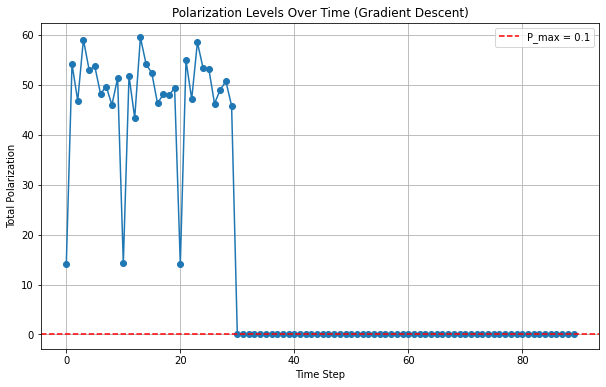

In [119]:
# Plot polarization levels over time
plt.figure(figsize=(10, 6))
plt.plot(range(len(polarization_levels)), polarization_levels, marker="o")
plt.title("Polarization Levels Over Time (Gradient Descent)")
plt.xlabel("Time Step")
plt.ylabel("Total Polarization")
plt.axhline(y=polarization_max[0], color="r", linestyle="--", label=f"P_max = {polarization_max[0]}")
plt.legend()
plt.grid()
plt.show()

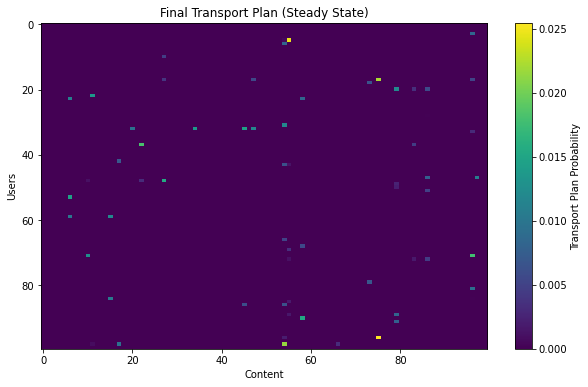

In [75]:
# Plot the final transport plan
plt.figure(figsize=(10, 6))
plt.imshow(transport_plans[-1], aspect="auto", cmap="viridis")
plt.colorbar(label="Transport Plan Probability")
plt.title("Final Transport Plan (Steady State)")
plt.xlabel("Content")
plt.ylabel("Users") 
plt.show()